In [ ]:

!git clone https://github.com/isaaccorley/pytorch-enhance
%cd pytorch-enhance
!python setup.py install
!pip install poutyne
! pip install scikit-video

Cloning into 'pytorch-enhance'...
remote: Enumerating objects: 972, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 972 (delta 109), reused 163 (delta 106), pack-reused 784
Receiving objects: 100% (972/972), 29.78 MiB | 34.81 MiB/s, done.
Resolving deltas: 100% (579/579), done.
/content/pytorch-enhance
/usr/local/lib/python3.9/dist-packages/setuptools/dist.py:788: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/__init__.py:85: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated. Requirements should be satisfied by a PEP 517 installer. If you are using pip, you can try `pip install --use-pep517`.
  dist.fetch_build_eggs(dist.setup_requires)
/usr/local/lib/python3.9/dist-packages/setuptools/dist.py:788: UserWarning: Usage

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch_enhance
import os
import tqdm
import cv2
import skimage
import skvideo.io
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch.utils.data import DataLoader

from poutyne.framework import Model

from torch_enhance.datasets import BSDS300, Set14, Set5
from torch_enhance.models import SRCNN
from torch_enhance import metrics


scale_factor = 2
train_dataset = BSDS300(scale_factor=scale_factor)
val_dataset = Set14(scale_factor=scale_factor)
train_dataloader = DataLoader(train_dataset, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_size=2)

channels = 3 if train_dataset.color_space == "RGB" else 1
pytorch_network = torch_enhance.models.ESPCN(scale_factor=2)

model = Model(
    pytorch_network,
    'adam',
    "mse"
)
path='/content/drive/My Drive/Models/super-res.pt'
model.load_weights(path)

# model.fit_generator(
#     train_dataloader,
#     val_dataloader,
#     epochs=1
# )

100%|██████████| 22211847/22211847 [00:00<00:00, 22811125.92it/s]


Extracting /content/pytorch-enhance/.data/BSDS300-images.tgz to /content/pytorch-enhance/.data


5096261it [00:00, 130852430.29it/s]


<All keys matched successfully>

In [ ]:
train_dataset[0][1].shape

torch.Size([3, 256, 256])

In [ ]:
def resize_frames(arr, i_width=640, i_height=480):
  videodata__=np.zeros((arr.shape[0], i_height, i_width, 3), dtype=np.float32)
  for i in range(arr.shape[0]):
    videodata__[i]=cv2.resize(arr[i], (i_width, i_height))
  return videodata__

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def process_frame(arr):
  img0=(torch.tensor(arr.transpose(2, 0, 1), dtype=torch.float32).to(device)/255.).unsqueeze(0)
  n, c, h, w = img0.shape
  ph = ((h - 1) // 32 + 1) * 32
  pw = ((w - 1) // 32 + 1) * 32
  padding = (0, pw - w, 0, ph - h)
  img0 = F.pad(img0, padding)
  return img0

def post_process(img):
  return img.cpu().detach().numpy().transpose(1, 2, 0)

def get_ith_frame(data, i=0):
  img0=process_frame(data[i])
  img1=process_frame(data[i+2])
  img_mid_actual=process_frame(data[i+1])
  return torch.cat([img0, img1], dim=1), img_mid_actual

In [ ]:
folder_path =( r"/content/drive/MyDrive/Video_/Ambulance_Videos/VIDEOS")
videos_list = os.listdir(folder_path)
videos_list = map(( lambda x: '/' + x), videos_list)
videos_list = list(filter(lambda x : x.endswith(".mp4"), videos_list))

In [ ]:
gen_list = [skvideo.io.FFmpegReader(folder_path+vid) for vid in videos_list]
vid_shape = [3, *gen_list[0].getShape()[1:]]

In [ ]:
next(gen_list[0]).shape

(1080, 1920, 3)

In [ ]:
gen_list[0].getShape()[1:]

(1080, 1920, 3)

In [ ]:
shapex, shapey = 1920//4, 1080//4

In [ ]:
num_batches = 50
videos_per_batch = 5

In [ ]:

pbar = tqdm.tqdm(range(num_batches))
iter=0

for _ in pbar:

  train_X, train_Y=[], []
  indices=np.random.randint(low=0, high=len(videos_list), size=videos_per_batch)
  for i in indices:
    try:
      data=next(gen_list[i])
    except:
      gen_list[i]=skvideo.io.FFmpegReader(folder_path+videos_list[i])
      data=next(gen_list[i])
      print("here")

    train_X.append(cv2.resize(data, (shapex//2, shapey//2)).transpose(2, 0, 1)/255)
    train_Y.append(cv2.resize(data, (shapex, shapey)).transpose(2, 0, 1)/255)

  train_X=torch.from_numpy(np.array(train_X, dtype=np.float32))
  train_Y=torch.from_numpy(np.array(train_Y, dtype=np.float32))

  model.fit(train_X, train_Y, epochs=100, verbose=True)
  # if iter%10==0:
  #   res=model.fit_generator(train_dataloader, val_dataloader, epochs=1, verbose=False)
  #   pbar.set_description(f"Loss: {float(res[0]['val_loss']):.4f}")
  iter+=1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   1/100 Train steps: 1 3.40s loss: 0.004321                              
Epoch:   2/100 Train steps: 1 1.83s loss: 0.052759                              
Epoch:   3/100 Train steps: 1 1.37s loss: 0.007905                              
Epoch:   4/100 Train steps: 1 1.36s loss: 0.010952                              
Epoch:   5/100 Train steps: 1 1.63s loss: 0.018973                              
Epoch:   6/100 Train steps: 1 2.46s loss: 0.017017                              
Epoch:   7/100 Train steps: 1 2.49s loss: 0.012951                              
Epoch:   8/100 Train steps: 1 5.08s loss: 0.011079                              
Epoch:   9/100 Train steps: 1 5.57s loss: 0.010192                              
Epoch:  10/100 Train steps: 1 2.41s loss: 0.009875                              
Epoch:  11/100 Train steps: 1 1.29s loss: 0.010233                              
Epoch:  12/100 Train steps: 1 1.30s loss: 0.010317                              
Epoch:  13/100 Train steps: 

 10%|█         | 1/10 [02:52<25:50, 172.24s/it]

Epoch:   1/100 Train steps: 1 2.14s loss: 0.003759                              
Epoch:   2/100 Train steps: 1 1.41s loss: 0.003603                              
Epoch:   3/100 Train steps: 1 1.34s loss: 0.003402                              
Epoch:   4/100 Train steps: 1 1.31s loss: 0.003270                              
Epoch:   5/100 Train steps: 1 1.33s loss: 0.003264                              
Epoch:   6/100 Train steps: 1 1.34s loss: 0.003313                              
Epoch:   7/100 Train steps: 1 1.31s loss: 0.003283                              
Epoch:   8/100 Train steps: 1 1.44s loss: 0.003155                              
Epoch:   9/100 Train steps: 1 1.73s loss: 0.003141                              
Epoch:  10/100 Train steps: 1 2.10s loss: 0.003159                              
Epoch:  11/100 Train steps: 1 2.14s loss: 0.003171                              
Epoch:  12/100 Train steps: 1 2.04s loss: 0.003072                              
Epoch:  13/100 Train steps: 

 20%|██        | 2/10 [05:31<21:54, 164.36s/it]

Epoch:   1/100 Train steps: 1 1.34s loss: 0.002163                              
Epoch:   2/100 Train steps: 1 1.33s loss: 0.002163                              
Epoch:   3/100 Train steps: 1 1.92s loss: 0.002155                              
Epoch:   4/100 Train steps: 1 2.19s loss: 0.002146                              
Epoch:   5/100 Train steps: 1 2.15s loss: 0.002143                              
Epoch:   6/100 Train steps: 1 2.09s loss: 0.002136                              
Epoch:   7/100 Train steps: 1 1.53s loss: 0.002133                              
Epoch:   8/100 Train steps: 1 1.35s loss: 0.002129                              
Epoch:   9/100 Train steps: 1 1.37s loss: 0.002119                              
Epoch:  10/100 Train steps: 1 1.37s loss: 0.002116                              
Epoch:  11/100 Train steps: 1 1.34s loss: 0.002114                              
Epoch:  12/100 Train steps: 1 1.35s loss: 0.002107                              
Epoch:  13/100 Train steps: 

 30%|███       | 3/10 [08:14<19:06, 163.83s/it]

Epoch:   1/100 Train steps: 1 1.33s loss: 0.001888                              
Epoch:   2/100 Train steps: 1 1.35s loss: 0.001882                              
Epoch:   3/100 Train steps: 1 1.30s loss: 0.001876                              
Epoch:   4/100 Train steps: 1 1.35s loss: 0.001870                              
Epoch:   5/100 Train steps: 1 1.32s loss: 0.001865                              
Epoch:   6/100 Train steps: 1 1.32s loss: 0.001860                              
Epoch:   7/100 Train steps: 1 2.01s loss: 0.001856                              
Epoch:   8/100 Train steps: 1 2.14s loss: 0.001851                              
Epoch:   9/100 Train steps: 1 2.11s loss: 0.001848                              
Epoch:  10/100 Train steps: 1 2.06s loss: 0.001844                              
Epoch:  11/100 Train steps: 1 1.47s loss: 0.001841                              
Epoch:  12/100 Train steps: 1 1.37s loss: 0.001837                              
Epoch:  13/100 Train steps: 

 40%|████      | 4/10 [10:56<16:20, 163.36s/it]

Epoch:   1/100 Train steps: 1 2.13s loss: 0.001329                              
Epoch:   2/100 Train steps: 1 1.95s loss: 0.001473                              
Epoch:   3/100 Train steps: 1 1.37s loss: 0.002009                              
Epoch:   4/100 Train steps: 1 1.33s loss: 0.003924                              
Epoch:   5/100 Train steps: 1 1.33s loss: 0.006434                              
Epoch:   6/100 Train steps: 1 1.34s loss: 0.008566                              
Epoch:   7/100 Train steps: 1 1.36s loss: 0.002180                              
Epoch:   8/100 Train steps: 1 1.32s loss: 0.007070                              
Epoch:   9/100 Train steps: 1 1.29s loss: 0.005284                              
Epoch:  10/100 Train steps: 1 1.81s loss: 0.005057                              
Epoch:  11/100 Train steps: 1 2.20s loss: 0.004092                              
Epoch:  12/100 Train steps: 1 2.14s loss: 0.004228                              
Epoch:  13/100 Train steps: 

 50%|█████     | 5/10 [13:37<13:32, 162.48s/it]

Epoch:   1/100 Train steps: 1 1.33s loss: 0.001466                              
Epoch:   2/100 Train steps: 1 1.65s loss: 0.001461                              
Epoch:   3/100 Train steps: 1 2.14s loss: 0.001453                              
Epoch:   4/100 Train steps: 1 2.12s loss: 0.001446                              
Epoch:   5/100 Train steps: 1 2.10s loss: 0.001439                              
Epoch:   6/100 Train steps: 1 1.87s loss: 0.001433                              
Epoch:   7/100 Train steps: 1 1.35s loss: 0.001427                              
Epoch:   8/100 Train steps: 1 1.35s loss: 0.001422                              
Epoch:   9/100 Train steps: 1 1.32s loss: 0.001417                              
Epoch:  10/100 Train steps: 1 1.42s loss: 0.001412                              
Epoch:  11/100 Train steps: 1 1.41s loss: 0.001407                              
Epoch:  12/100 Train steps: 1 1.35s loss: 0.001402                              
Epoch:  13/100 Train steps: 

 60%|██████    | 6/10 [16:22<10:52, 163.12s/it]

Epoch:   1/100 Train steps: 1 1.36s loss: 0.001732                              
Epoch:   2/100 Train steps: 1 1.38s loss: 0.001726                              
Epoch:   3/100 Train steps: 1 1.36s loss: 0.001719                              
Epoch:   4/100 Train steps: 1 1.34s loss: 0.001714                              
Epoch:   5/100 Train steps: 1 1.73s loss: 0.001709                              
Epoch:   6/100 Train steps: 1 2.16s loss: 0.001705                              
Epoch:   7/100 Train steps: 1 2.15s loss: 0.001699                              
Epoch:   8/100 Train steps: 1 2.08s loss: 0.001694                              
Epoch:   9/100 Train steps: 1 1.85s loss: 0.001690                              
Epoch:  10/100 Train steps: 1 1.39s loss: 0.001686                              
Epoch:  11/100 Train steps: 1 1.38s loss: 0.001682                              
Epoch:  12/100 Train steps: 1 1.34s loss: 0.001678                              
Epoch:  13/100 Train steps: 

 70%|███████   | 7/10 [19:06<08:10, 163.39s/it]

Epoch:   1/100 Train steps: 1 1.47s loss: 0.001527                              
Epoch:   2/100 Train steps: 1 1.26s loss: 0.001524                              
Epoch:   3/100 Train steps: 1 1.35s loss: 0.001518                              
Epoch:   4/100 Train steps: 1 1.37s loss: 0.001516                              
Epoch:   5/100 Train steps: 1 1.39s loss: 0.001510                              
Epoch:   6/100 Train steps: 1 1.32s loss: 0.001505                              
Epoch:   7/100 Train steps: 1 1.36s loss: 0.001502                              
Epoch:   8/100 Train steps: 1 1.58s loss: 0.001497                              
Epoch:   9/100 Train steps: 1 2.21s loss: 0.001493                              
Epoch:  10/100 Train steps: 1 2.23s loss: 0.001488                              
Epoch:  11/100 Train steps: 1 2.19s loss: 0.001485                              
Epoch:  12/100 Train steps: 1 2.02s loss: 0.001482                              
Epoch:  13/100 Train steps: 

 80%|████████  | 8/10 [21:49<05:27, 163.54s/it]

Epoch:   1/100 Train steps: 1 2.15s loss: 0.001279                              
Epoch:   2/100 Train steps: 1 2.10s loss: 0.001279                              
Epoch:   3/100 Train steps: 1 1.84s loss: 0.001277                              
Epoch:   4/100 Train steps: 1 1.37s loss: 0.001274                              
Epoch:   5/100 Train steps: 1 1.38s loss: 0.001270                              
Epoch:   6/100 Train steps: 1 1.37s loss: 0.001266                              
Epoch:   7/100 Train steps: 1 1.35s loss: 0.001261                              
Epoch:   8/100 Train steps: 1 1.31s loss: 0.001257                              
Epoch:   9/100 Train steps: 1 1.36s loss: 0.001253                              
Epoch:  10/100 Train steps: 1 1.32s loss: 0.001251                              
Epoch:  11/100 Train steps: 1 2.18s loss: 0.001248                              
Epoch:  12/100 Train steps: 1 2.13s loss: 0.001246                              
Epoch:  13/100 Train steps: 

 90%|█████████ | 9/10 [24:34<02:43, 163.69s/it]

Epoch:   1/100 Train steps: 1 1.36s loss: 0.000995                              
Epoch:   2/100 Train steps: 1 1.97s loss: 0.000995                              
Epoch:   3/100 Train steps: 1 2.09s loss: 0.001002                              
Epoch:   4/100 Train steps: 1 2.11s loss: 0.001033                              
Epoch:   5/100 Train steps: 1 2.15s loss: 0.001144                              
Epoch:   6/100 Train steps: 1 1.49s loss: 0.001555                              
Epoch:   7/100 Train steps: 1 1.31s loss: 0.002626                              
Epoch:   8/100 Train steps: 1 1.38s loss: 0.005721                              
Epoch:   9/100 Train steps: 1 1.35s loss: 0.005207                              
Epoch:  10/100 Train steps: 1 1.35s loss: 0.003880                              
Epoch:  11/100 Train steps: 1 1.36s loss: 0.001158                              
Epoch:  12/100 Train steps: 1 1.34s loss: 0.003912                              
Epoch:  13/100 Train steps: 

100%|██████████| 10/10 [27:17<00:00, 163.78s/it]


In [ ]:
data=next(gen_list[0])
test_d = cv2.resize(data, (shapex//2, shapey//2)).transpose(2, 0, 1)/255
test_d=torch.from_numpy(np.array(test_d, dtype=np.float32))
pred=model.predict(test_d)

Prediction steps: 1 0.09s                          


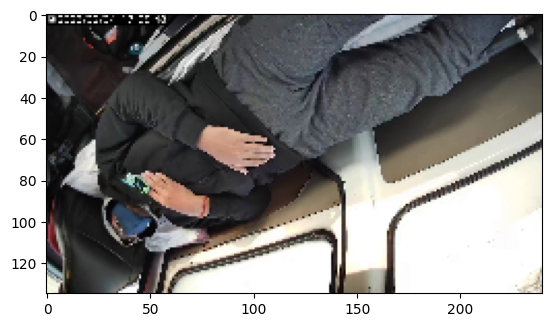

In [ ]:
plt.imshow(test_d.numpy().transpose(1, 2, 0))

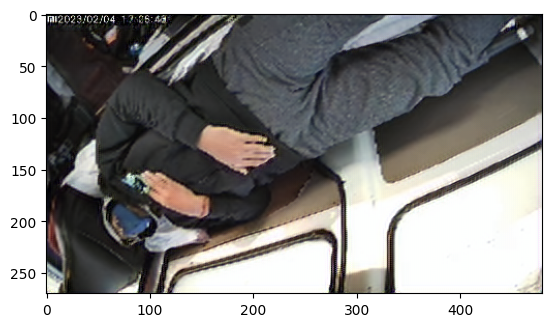

In [ ]:
plt.imshow(pred.transpose(1, 2, 0))

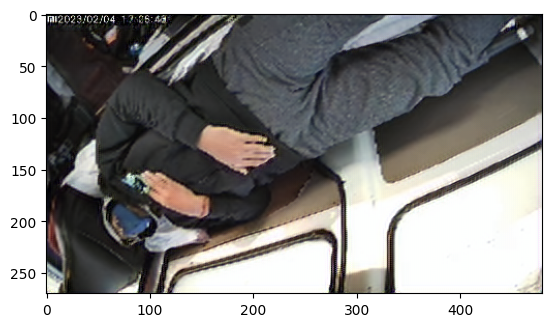

In [ ]:
plt.imshow(pred.transpose(1, 2, 0))

In [ ]:
new_path='/content/drive/My Drive/Models/super-res-amb.pt'
model.save_weights(new_path)

In [ ]:
model.load_weights(new_path)

<All keys matched successfully>

In [ ]:
vid = skvideo.io.FFmpegReader(folder_path+videos_list[0])

In [ ]:
write_f = skvideo.io.FFmpegWriter(folder_path+'/super-res.mp4')

In [ ]:
all_f=[]
for frame in vid.nextFrame():
  frame=cv2.resize(frame, (shapex//2, shapey//2))
  # all_f.append(frame)
  continue
  frame=frame.transpose(2, 0, 1)/255
  frame=torch.from_numpy(np.array(frame, dtype=np.float32))
  frame=model.predict(frame, verbose=False).transpose(1, 2, 0)
  arr=np.array(frame*255, dtype=np.int32)
  arr[arr<0]=0
  write_f.writeFrame(arr)
write_f.close()

In [ ]:
all_f2=np.array(all_f)
all_f2.shape

(1199, 135, 240, 3)

In [ ]:
all_f2=all_f2.transpose(0, 3, 1, 2)/255
all_f2=torch.from_numpy(np.array(all_f2, dtype=np.float32))


In [ ]:
model.predict_on_batch(all_f2)